In [2]:
!pip3 install tensorflow

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [6]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [7]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [11]:
df = pd.read_csv('../datasets/internet.csv')
df.head()
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'entity': 'Country'}, inplace=True)
df = df.ffill().bfill()
df.head()

,Country,code,Internet Usage (% of Population) 1990,Internet Usage (% of Population) 1991,Internet Usage (% of Population) 1992,Internet Usage (% of Population) 1993,Internet Usage (% of Population) 1994,Internet Usage (% of Population) 1995,Internet Usage (% of Population) 1996,Internet Usage (% of Population) 1997,...,Internet Usage (% of Population) 2014,Internet Usage (% of Population) 2015,Internet Usage (% of Population) 2016,Internet Usage (% of Population) 2017,Internet Usage (% of Population) 2018,Internet Usage (% of Population) 2019,Internet Usage (% of Population) 2020,Internet Usage (% of Population) 2021,Internet Usage (% of Population) 2022,Internet Usage (% of Population) 2023
0,Afghanistan,AFG,0,0,0,0,0,0,0.032196828,0.048593919,...,7,8.26,11,13.5,16.8,17.6,18.4,79.3237,82.6137,83.1356
1,Albania,ALB,0,0,0,0,0,0.011168695,0.032196828,0.048593919,...,54.3,56.9,59.6,62.4,65.4,68.5504,72.2377,79.3237,82.6137,83.1356
2,Algeria,DZA,0,0,0,0,0.000360674,0.001768954,0.001738533,0.010268463,...,29.5,38.2,42.9455,47.6911,49.0385,58.9776,60.6534,66.2356,71.2432,83.1356
3,American Samoa,ASM,0,0,0,0,0,0,0.001738533,0.010268463,...,29.5,38.2,42.9455,47.6911,49.0385,58.9776,60.6534,66.2356,71.2432,83.1356
4,Andorra,AND,0,0,0,0,0,0,1.526601023,3.050175385,...,86.1,87.9,89.7,91.5675,49.0385,90.7187,93.2056,93.8975,94.4855,83.1356


In [12]:
cols = [col for col in df.columns if 'Internet' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [13]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Afghanistan
Epoch [50/200], Loss: 0.0116
Epoch [100/200], Loss: 0.0108
Epoch [150/200], Loss: 0.0117
Epoch [200/200], Loss: 0.0074

Training model for Albania
Epoch [50/200], Loss: 0.0112
Epoch [100/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0053
Epoch [200/200], Loss: 0.0028

Training model for Algeria
Epoch [50/200], Loss: 0.0035
Epoch [100/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0012

Training model for American Samoa
Epoch [50/200], Loss: 0.0019
Epoch [100/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0013
Epoch [200/200], Loss: 0.0014

Training model for Andorra
Epoch [50/200], Loss: 0.0250
Epoch [100/200], Loss: 0.0103
Epoch [150/200], Loss: 0.0118
Epoch [200/200], Loss: 0.0087

Training model for Angola
Epoch [50/200], Loss: 0.0086
Epoch [100/200], Loss: 0.0066
Epoch [150/200], Loss: 0.0066
Epoch [200/200], Loss: 0.0077

Training model for Antigua and Barbuda
Epoch [50/200], Loss: 0.0021
Epoch [100/200], Loss: 0.0009
Epoch [15

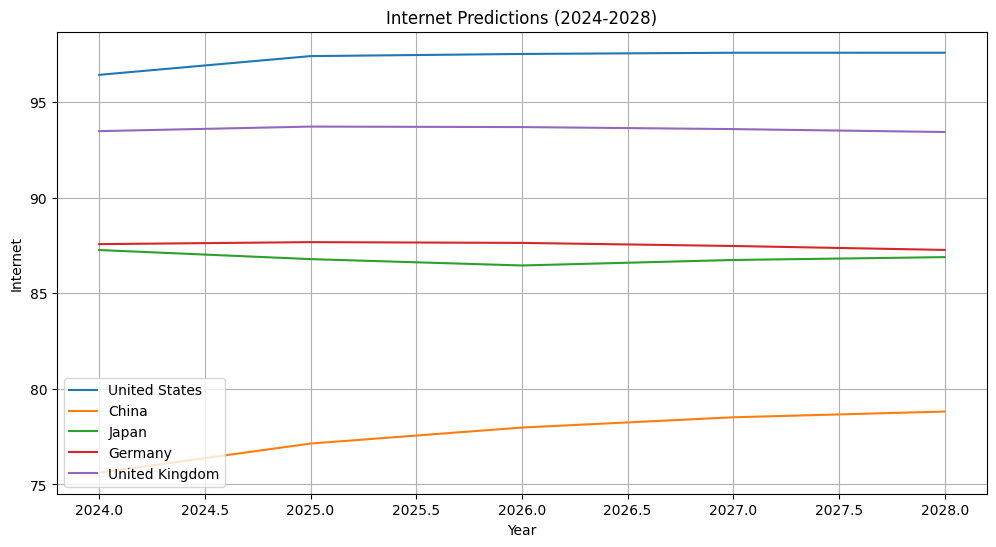


Predicted Internet (2024-2028):

United States:
2024: $96.44
2025: $97.42
2026: $97.53
2027: $97.59
2028: $97.59

China:
2024: $75.61
2025: $77.14
2026: $77.98
2027: $78.51
2028: $78.81

Japan:
2024: $87.27
2025: $86.79
2026: $86.46
2027: $86.75
2028: $86.90

Germany:
2024: $87.58
2025: $87.68
2026: $87.64
2027: $87.48
2028: $87.27

United Kingdom:
2024: $93.49
2025: $93.73
2026: $93.70
2027: $93.60
2028: $93.44


In [14]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('Internet Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Internet')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted Internet (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [16]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2024, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2024])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} Internet'] = year_predictions

predictions_df.to_csv('../lstm_datasets/internet_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/internet_prediction.csv")



Predictions exported to lstm_datasets/internet_prediction.csv
